In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import os
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
from wordcloud import WordCloud, STOPWORDS
from __future__ import print_function
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.colheader_justify', 'left')
from IPython.display import display, HTML

# Crunchbase data

This set of data acquired through Crunchbase Pro subscription and manual download of CSVs.

Company founded between 2010 and 2016 in **Data and Analytics** category group: ```crunchbase_data/overall_company_list.csv```

Acquisition occurred between 2010 and 2016 in all categories: ```crunchbase_data/cb_acquisitions/*csv```

In [2]:
cb_data = pd.read_csv('crunchbase_data/overall_company_list.csv', index_col=0)
# cb_data = cb_data.drop_duplicates(subset=['Company Name', 'Website'])
cb_data = cb_data.drop_duplicates(subset=['Company Name'])
cb_data.year = cb_data.year.astype(int)
cb_data = cb_data.rename(columns={'year': 'Founded Year'})
print(cb_data.shape)
cb_data.head()

(8350, 28)


,Company Name,Category Groups,Headquarters Location,Description,Crunchbase Rank,Founded Date,Number of Articles,Total Equity Funding Amount,Total Funding Amount,Closed Date,...,IPO Date,Money Raised at IPO,Valuation at IPO,Stock Symbol,Stock Exchange,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Website,Founded Year
0,Krux,"Media and Entertainment, Data and Analytics, Sales and Marketing, Advertising","San Francisco, California, United States","Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.",35,2010-01-01,91,"$50,000,000","$50,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,7.4,9.4,9.6,http://www.krux.com,2010
1,Datadog,"Information Technology, Data and Analytics, Software","New York, New York, United States",Datadog is the essential monitoring service for dynamic cloud infrastructure.,374,2010-01-01,95,"$147,900,000","$147,900,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-0.5,-1.3,http://datadog.com,2010
2,Sumo Logic,"Data and Analytics, Software","Redwood City, California, United States","Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence.",407,2010-01-01,128,"$155,000,000","$155,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-1.2,0.6,http://www.sumologic.com,2010
3,Quid,"Information Technology, Data and Analytics, Software, Design","San Francisco, California, United States","Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.",709,2010-01-01,44,"$66,500,000","$66,500,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,2.5,http://quid.com,2010
4,Vicarious,"Media and Entertainment, Data and Analytics, Software, Video","San Francisco, California, United States","Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.",718,2010-01-01,33,"$72,000,000","$72,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,-1.4,http://vicarious.com,2010


In [3]:
acq_file_list = glob.glob('crunchbase_data/cb_acquisitions/*csv')
dfs = []
for f in acq_file_list:
    dfs.append(pd.read_csv(f))
acq_df = pd.concat(dfs, ignore_index=True)
acq_df = acq_df.drop_duplicates(subset=['Acquired Company Name'])

acq_df['Acquired Year'] = acq_df['Announced On Date'].apply(lambda x: int(x[-4:])) # extract year from date string

print(acq_df.shape)
acq_df.head()

(3729, 6)


,Transaction Name,Acquired Company Name,Acquiring Company Name,Announced On Date,Price,Acquired Year
0,Centric Health Corp. acquires CareRx,CareRx,Centric Health Corp.,09/22/2016,"$14,000,000",2016
1,Warburg Pincus acquires Ascentium Capital,Ascentium Capital,Warburg Pincus,10/04/2016,NaN,2016
2,Sharecare acquires BioLucid,BioLucid,Sharecare,09/29/2016,NaN,2016
3,Google acquires Api.ai,Api.ai,Google,09/19/2016,NaN,2016
4,Demand Media acquires The Other Art Fair,The Other Art Fair,Demand Media,09/16/2016,NaN,2016


In [4]:
# name_dup = cb_data[cb_data['Company Name'].duplicated(keep=False)].sort_values('Company Name')['Company Name']

In [5]:
# cb_data.loc[name_dup.index]

In [6]:
# cb_cname = cb_data['Company Name']
# acq_cname = acq_df['Acquired Company Name']
# print len(set(cb_cname))
# print len(set(acq_cname))
# print len(set(cb_cname.values) & set(acq_cname.values))

In [7]:
cb_data_merged = cb_data.merge(acq_df, how='left', left_on='Company Name', right_on='Acquired Company Name')

In [8]:
cb_data_merged.shape

(8350, 34)

# Acquisition over time

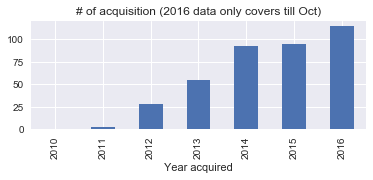

In [13]:
n_acq = cb_data_merged['Acquired Year'].value_counts(sort=False).sort_index()
n_acq.loc[[2010, 2011, 2012, 2013, 2014, 2015, 2016]].plot(kind='bar', figsize=(6,2))
plt.title('# of acquisition (2016 data only covers till Oct)')
plt.xlabel('Year acquired')

## Word cloud of company description over time

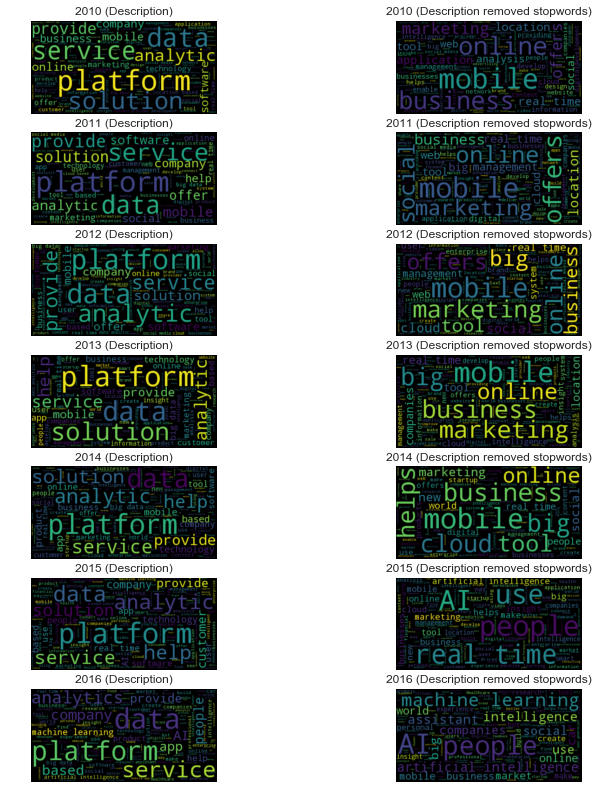

In [9]:
stopwords = set(STOPWORDS)
stopwords = stopwords.union({'product', 'technology', 'data', 'company', 'customer', 'analytic', 
                             'platform', 'analytics', 'provide', 'service', 'solution', 'provides', 'offer', 'help',
                            'software', 'solutions', 'app', 'based', 'services', 'user', 'offer'})
plt.figure(figsize=(12,14))
i = 1
for y in range(2010, 2017):
    text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y].Description.values))

    wordcloud = WordCloud(max_font_size=60).generate(text)
    plt.subplot(7, 2, i)    
    i+=1
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(y) + ' (Description)')
    
    wordcloud = WordCloud(max_font_size=60, stopwords=stopwords).generate(text)
    plt.subplot(7, 2, i)    
    i+=1
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(y)+' (Description removed stopwords)')
    
#     text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y]['Categories'].values))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 4, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Categories tag)')
    
#     text = ' '.join(list(cb_data_merged[cb_data_merged['Founded Year'] == y]['Category Groups'].values))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 4, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Category Groups tag)')
    
    #plt.show()

In [10]:
# cb_data_merged['time_to_acq'] = cb_data_merged['Acquired Year'] - cb_data_merged['Founded Year']
# tmp_df = cb_data_merged[['Company Name', 'Founded Year', 'Acquired Year', 'time_to_acq']]
# tmp_df = tmp_df.dropna(axis=0)
# g = sns.factorplot(x="Founded Year", y="time_to_acq", data=tmp_df,
#                    size=6, kind="bar", palette="muted")
# g.despine(left=True)
# g.set_ylabels("survival probability")
# tmp_df

# See how many company names end with .ai

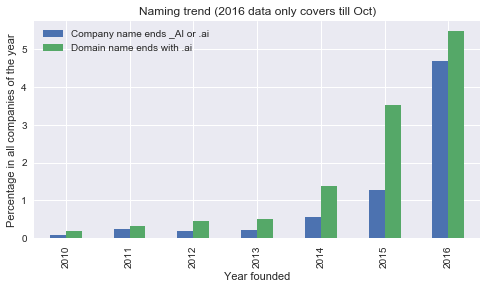

In [14]:
n_company = cb_data_merged['Founded Year'].value_counts().sort_index()
n_company.name = 'N company'

ai_names = cb_data_merged[cb_data_merged['Company Name'].str.endswith(' AI') | 
                          cb_data_merged['Company Name'].str.endswith('.ai')]['Founded Year'].value_counts(sort=False)
ai_names = ai_names / n_company *100
ai_names.name = 'Company name ends _AI or .ai'

ai_websites = cb_data_merged[cb_data_merged['Website'].str.endswith('.ai').fillna(False)]['Founded Year'].value_counts(sort=False)
ai_websites = ai_websites / n_company *100
ai_websites.name = 'Domain name ends with .ai'

io_websites = cb_data_merged[cb_data_merged['Website'].str.endswith('.io').fillna(False)]['Founded Year'].value_counts(sort=False)
io_websites = io_websites / n_company *100
io_websites.name = 'Domain name ends with .io'

#ai_df = pd.concat([ai_names, ai_websites, io_websites], axis=1)
ai_df = pd.concat([ai_names, ai_websites], axis=1)
ai_df.plot(kind='bar', figsize=(8,4))
plt.title('Naming trend (2016 data only covers till Oct)')
plt.xlabel('Year founded')
plt.ylabel('Percentage in all companies of the year')

In [15]:
print(cb_data_merged.shape)
cb_data_merged.dropna(subset=['Description'], inplace=True)
# want to make sure a company has a description for further analysis
print(cb_data_merged.shape)
cb_data_merged.dropna(subset=['Company Name'], inplace=True)
# want to make sure a company has a description for further analysis
print(cb_data_merged.shape)

(8350, 34)
(8350, 34)
(8350, 34)


In [16]:
print(len(cb_data_merged['Company Name']) - len(cb_data_merged['Company Name'].unique()))

0


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(input='content', 
                    encoding='utf-8', decode_error='replace', strip_accents='unicode', 
                    lowercase=True, analyzer='word', stop_words='english', 
                    ngram_range=(1, 2), max_features = 10000, 
                    norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True,
                    max_df=1.0, min_df=1)

In [19]:
corpus = cb_data_merged['Description']
v.fit(corpus)
X = v.transform(corpus)
#print(v.vocabulary_)
print(X.shape)

(8350, 10000)


In [20]:
def calc_sim(X, df, company_name_col):
    # calculate siimlarity based on tfidf vector of the company description
    try:
        X = X.todense() # originally it's a sparse matrix
    except:
        pass
    sim_dict = {}
    N_sim = 50
    batch_size = 200
    for i in tqdm(range(0,len(df),batch_size)):
        i1 = min(len(df), i+batch_size)
        xquery = X[i:i1] # BxD
        ds = -np.asarray(np.dot(X, xquery.T)) #NxD * DxB => NxB
        IX = np.argsort(ds, axis=0) # NxB
        for j in range(i1-i):
            sim_dict[df.loc[i+j, company_name_col]] = \
            [(df.loc[q, company_name_col], ds[q,j]) for q in list(IX[:N_sim,j])]
    return sim_dict

In [21]:
sim_dict_CB = calc_sim(X, cb_data_merged, 'Company Name')

100%|██████████| 42/42 [00:28<00:00,  1.47it/s]


In [23]:
def build_recommendation_table(company_name, sim_dict, df, company_name_col, description_col, label_col=None, N=5):
    counter = 0
    entry_list = []
    for i in sim_dict[company_name]:
        d = {'title': i[0], 'proba': i[1], 
             'description': list(df[df[company_name_col]==i[0]][description_col])[0]}
        if label_col is not None:
            d['label'] = list(df[df[company_name_col]==i[0]][label_col])[0]
        entry_list.append(d)
    rec = pd.DataFrame(entry_list)
    #rec = rec.set_index('title')
    return rec.head(N)

In [24]:
#sim_dict_CB['Datadog']

In [26]:
c_list = ['Clarifai', 'Krux', 'Datadog', 'Insight Data Science']
for c in c_list:
    rec = build_recommendation_table(c, sim_dict_CB, cb_data_merged, 'Company Name', 'Description', 'Category Groups')
    display(rec)

,description,label,proba,title
0,Clarifai provides advanced image recognition systems for customers to detect near-duplicates and visual searches.,"Data and Analytics, Software, Internet Services",-1.000000,Clarifai
1,Revolutionary Image Recognition Fashion Platform,"Data and Analytics, Software",-0.352910,Demere
2,On-device Image Recognition Search for iOS,"Science and Engineering, Data and Analytics, Software, Internet Services, Mobile",-0.347923,Memkite
3,Sales through image recognition technology,"Platforms, Apps, Data and Analytics, Software, Mobile",-0.347460,SaveUp.pl
4,JustVisual is a leading visual search and image recognition technology company.,"Data and Analytics, Software, Internet Services",-0.304212,JustVisual


,description,label,proba,title
0,"Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.","Media and Entertainment, Data and Analytics, Sales and Marketing, Advertising",-1.000000,Krux
1,"IJudge is an online platform that ranks its users opinions, content, and URLs for the use of consumers, publishers, and agencies.","Data and Analytics, Internet Services, Design, Advertising",-0.254532,IJudge
2,"Rundown is an app to forecast audience demand and resource availability for professional content teams in brands, publishers and agencies.","Media and Entertainment, Data and Analytics, Software, Sales and Marketing, Internet Services, Advertising",-0.252606,Rundown App
3,Skroot helps marketers uncover who's in their target audience.,Data and Analytics,-0.230528,Skroot
4,There's a huge industry that's grown up around optimizing corporate web sites to drive revenue and customer loyalty.,"Information Technology, Data and Analytics, Software, Internet Services, Messaging and Telecommunications",-0.224656,Brightmetrics


,description,label,proba,title
0,Datadog is the essential monitoring service for dynamic cloud infrastructure.,"Information Technology, Data and Analytics, Software",-1.000000,Datadog
1,CloudVertical offers tools for tracking and analyzing cloud infrastructure usage and costs.,"Information Technology, Data and Analytics, Software, Internet Services",-0.343327,CloudVertical
2,Bllip is the essential wine app for oenophiles.,"Hardware, Data and Analytics, Software",-0.270979,Bllip
3,NodeQuery is provides a lightweight and easy to use linux server monitoring service.,"Data and Analytics, Software, Internet Services",-0.255900,NodeQuery
4,Essential intelligence for advertising sales teams.,"Data and Analytics, Software, Sales and Marketing, Advertising",-0.214635,AdWisdom


,description,label,proba,title
0,Insight Data Science is an intensive six week post-doctoral training fellowship bridging the gap between academia and data science.,"Data and Analytics, Education",-1.000000,Insight Data Science
1,Data Science without the headcount,"Information Technology, Data and Analytics, Software",-0.467226,Framed Data
2,Data science bootcamp,"Data and Analytics, Education",-0.467226,BayesCamp
3,Bridging the gap between ideas and technology,"Media and Entertainment, Data and Analytics, Events, Education, Internet Services, Mobile",-0.418341,Hoonio
4,twoXAR is a data science-driven biopharmaceutical company,"Data and Analytics, Software, Health Care",-0.378611,"twoXAR, Incorporated"


In [28]:
company_list = list(cb_data_merged['Company Name'].values)
company_list_file = 'company_list_CB.txt'
with open(company_list_file, 'w') as f:
    for c in company_list:
        f.write("%s\n" % c) 

# Enrich description through a bit of scraping

In [38]:
from scrape_google import *
target_url = 'https://www.crunchbase.com/organization/{}#/entity'
driver = init_driver()
shuffle(company_list)
for c in company_list:
    c_new = c.replace(' ', '-').replace(',', '-').replace('.', '-').replace('@','a').replace("'",'-')
    load_url(driver=driver, url=target_url.format(c_new))
    page = driver.page_source
    soup = BeautifulSoup(page, 'lxml')
    text = ''
    try:
        text = soup.findAll('div', {'class': 'description-ellipsis'})[0].get_text()
    except:
        log_time('error')
        print('failed to parse page')
    
    with open

Grand-Canal-Solutions
Practice-Ignition
Daily-Pnut
Semantile
Sense-Platform
ascribe
Pulzze-Systems--Inc
Leap-Labs
MobileForce-Software
StatusON
Kensee
GetFiXR
Strike-Social
KickRadius
Sprmarket
Sticki-Pages
Cleanly
SDLC-Services-Pvt--Ltd-
InstaTechie
RTSheet
cloud-infra-LLC
CloudKnots-LLC
Campalyst
vTEST
5-Analytics
Scoutible
Near
Unwired-Labs
Looker
DataClover
ROI-Checker
Leanplum
Body-Pass
Sotrender
Flowgear
Outcomes-Based-Healthcare-Ltd
HAAS-Alert
Fypp
SEO-Takeaways
Overl-ai
MarketHel
ILLUT-IO
Loop-Survey
LucidAct-Health
Lamppost
Dextro
LiveStories
EDRepublic
Deep-Genomics
PeopleMLS
Vertical-Mass
Animusoft
EdgeSpring
Context-Matters
Track
IQLECT
Winny
SmartBeings-Inc-
Hortonworks
MetricStory
ChatFirst
Allfollowers-info
hubally
Vector-Watch
Heureka-Software
i314
Vendscreen
Savanna
Hango
SynerScope
Taodyne
Whodini
Live-My-Journey
Rentalroost-com
SifData
Hyphen-AI
Touchsides
Wealth-X
Snaptor
Beyond-Verbal
YouEye
ViS
Avanteo-Consulting
ShiftFWD
BETHERE-APP-LTD-
RED-EHS
21-Inc
Draftpedia

Technobotz
Instanssi
BASE
LogoGrab
My-Band-Market
DeepVu
ai-type
Expert-Joe
Rundown-App
Ballstar
G&P-Marketing
Quack
VisitorEngage
TrustSphere
Checkealos
Evolita
ImpressTV
Seeq
GeLo
GinzaMetrics
AiMatchMaker
Urbinfo
LDRLY
Doss
Snap-Outdoors
NextUser
Fitsome-Inc
ingrain-io
i-ask
CloudNC
Crowded
Wibee
Crowdbabble
ZoomCharts
SherpaShare
Aisha
N-Toggle
DataPad
BrewCharts
Surveyors-Directory
Social-Intelligence
blabfeed
PlaceIQ
SIREn-Solutions
Workfuze
Simformer-com
Owler--Inc-
Fitfully
ConnectWithMe
MobileReady
INSIDER-
Joyride
DOKI-DOKI--INC-
Pixxa
CAP-Data-Technologies
FourLT-(4LT)-LLC
MavenSocial
Sparkling-Logic
BrightBytes
Coseer
Evergig
Klustera
Cloud-Technologies
Coosto
TryLIkes
ServiceLocale
Astronomer
MoBillions
WordsEye
InsightsOne
Infogr8
Calicom
Statwing
Vave
Telestratum-Networks
MonkeyData
BridgeU
Pazien
Mapsense
Truven-Health-Analytics
DataCapable
HotJar
Mention-LLC
SpazioDati
Bay31
Viewnine
Mobile-Commerce-Channel
Wise-Athena
EnhanceWorks--Inc-
GotIt!
msg-ai
Qualtera
Scopio
B

AeroState
Deepki
Qzzr
SeaUrchin-IO
Integromat
Sessionbox
gitgel-net
Light-Chaser-Animation
Connects-Marketing-Group
Footfeed
Loggr
Covalent-Data
LassoX
Uptake
Arachnys
Sententia-LLC
Ninja-Digital
Deveo
Vize-Software
Testive
Englue
tickle-me
The-Macro-Market
KarFarm
Copperpix-Inc-
WhereADbouts
Blackbird
Ezakus
ribl
Bee-Smart-Technologies
Semantic-Machines
Talix
Locate
Price-Ignite-Systems
archup
OvermediaCast
KBB-Partners
The-SafeCharge
RosenthalAnalysis
NuCivic
Loopd
PartyShouts
iLastic
Booklr
Beyond-Intelligence
Working-Social
Blackbird-Technologies
RTB-Media
Tandem
StreamSets
Niara--Inc-
Intellibrand
Finologic-Technologies-Private-Limited
Fraudlogix
ZetData
Visualino
Chicory
Qwery-Ninja
True-Fit
Sociagility
sensation-io
9Lenses
Regular-io
Gene-Guru
HealthQx
Laboratorio-para-La-Ciudad
Retail-IQ
easy2data
TELESPOT-Co-
Mindex
thesocialCV-com
MicroBlink
Amyx+
Liquid-Labs
Kingdom99
Mimmer
FindYourCloud-com
FitWell
Ovalpath
Rangespan
Exacaster
Wrangler
DICE
MyLikes
The-Social-Station
Rover

The-Hackerati
Gazoozle
Plarity
WebTeach
SlideIn
Enfuego-Technologies-LLC
Dripit-io
Fiddlehead-Technology
Freight-Prophet
Glocu
Graph-Grail
TOTEMS
ImageSurf-net
BirdSong-Analytics
Neuron-Soundware
Digital-Perception
Rulex
Worldwide-Investor-Network
Instics
Agile-Data-Decisions-LLC
Myfriday
D-A-M--Good-Media-Limited
GliaCloud
PlaceKnow
Quinto
Sonda41
Studycopter
Biotricity
SlamData
Water-Surveillance
OpenRisk
Bloom-Studio
RentalSpotter
DrumUp
PingTaxi
Shopper-Studio
Quickhelp
Bitness
Callida-Energy
one°-|-One-Degree
Trailhead
Dexi
Blupe
ThunderMaps
Citymart---Transforming-the-Way-Cities-Solve-Problems
Tellmeplus
EYWA-MEDIA
Pixuate
LookTracker
MIND-YOUR-GROUP
Fitroom
Sigtuple
Foretuit
SequenceIQ--Inc-
ShareRoot
Double-Blue-Sports-Analytics
Keepify
Continuum-Analytics
Aisle50
VCerto
Care-Analytics
VEM-Global
Meta-Data-Analytics-360
Antuit
oscadi
Fliptop
i3-membrane
Radius-Location-Technologies
Applied-Matter
Vibosity
Codalytics
Moneytree
Viva-Labs
Distal-Inc-
LinkIt
ScanMe
Olivia-AI
JetJaw

PacketSled
Profit-ly
Munetrix
Inception-Market-Intelligence
Debuggify-net
Lean-Survey
Rephraserz-Media-and-Communication-Services
LotaData--Inc-
Idiomatic
Vivastream
mysurf
Curalate
Targetta
Butter-ai


In [31]:
quit_driver(driver)

2017-07-05 22:23:50.980203 initiating driver: Chrome
2017-07-05 22:24:04.608434 page loaded successfully: https://www.crunchbase.com/organization/memkite#/entity
2017-07-05 22:24:04.639402 closing driver...


In [35]:
soup.findAll('div', {'class': 'description-ellipsis'})[0].get_text()

u'Memkite develops on-device Image Recognition Search software based on Deep Learning (Convolutional Neural Networks) that is being optimized to use GPU on iOS devices with Metal and Swift). The Memkite search engine is optimized to utilize SSD drive on mobile devices.\nExample of Large-Scale On-Device Search:\n1) Inverted Index Search \u2013 Able to do merging 5 posting lists with 100 Million URIs each in 25 millisecond on iPad Mini\nnote: with proper stop word handling, this would correspond to a billion document index\n2) Prefix Index (Instant Index) \u2013  0.5 billion index entries (60GB index) on an iPad Mini\n'

# Angellist data

Data acquired throuhg web scraping see repo [here](https://github.com/dingran1019/angellist-webscrape)


In [ ]:
angellist_data=pd.read_csv('angellist_data/results_so_far_2016-10-21.csv', index_col=0)
angellist_data['joined_year'] = angellist_data['joined_date'].apply(lambda x: int(x[:4]))
# extract year from date string
print(angellist_data.shape)
angellist_data.head(5)

In [ ]:
print(angellist_data.shape)
angellist_data.dropna(subset=['product_desc'], inplace=True)
# want to make sure a company has a description for further analysis
print(angellist_data.shape)
angellist_data.dropna(subset=['title'], inplace=True)
# want to make sure a company has a description for further analysis
print(angellist_data.shape)

In [ ]:
print(angellist_data.shape)
angellist_data = angellist_data.drop_duplicates(subset=['title', 'website'])
# consider a company a duplicate of both company name (title) and website are the same
print(angellist_data.shape)

In [ ]:
# check if we have duplicated name if so append '-2', '-3' and so on
for i in range(3):
    print(len(angellist_data.title) - len(angellist_data.title.unique()))  #see how many duplicated titles
    idx = angellist_data.title.duplicated()
    angellist_data.loc[idx, 'title'] = angellist_data.loc[idx, 'title'] + '-' + str(i+2)
print(angellist_data.shape)
#print(angellist_data[angellist_data.title.str.endswith('-3')].title)

assert 0 == len(angellist_data.title) - len(angellist_data.title.unique())

In [ ]:
len(angellist_data.market.unique())

In [ ]:
angellist_data = angellist_data.reset_index(drop=True)
angellist_data.index

In [ ]:
corpus = angellist_data.product_desc
v.fit(corpus)
X = v.transform(corpus)
#print(v.vocabulary_)
print(X.shape)

In [ ]:
sim_dict_AL = calc_sim(X, angellist_data, 'title')

In [ ]:
# list(angellist_data[angellist_data['title']=='Clarifai']['product_desc'])[0]

In [ ]:
# sim_dict['Acacia Communications']

In [ ]:
c_list = ['Clarifai', 'Dropbox', 'Atlassian', 'SpaceX', 'Acacia Communications']
for c in c_list:
    rec = build_recommendation_table(c, sim_dict_AL, angellist_data, 'title', 'product_desc','market')
    display(rec)

In [ ]:
# company_list = list(angellist_data.title.values)
# company_list_file = 'company_list.txt'
# with open(company_list_file, 'w') as f:
#     for c in company_list:
#         f.write("%s\n" % c)    

In [ ]:
# stopwords = set(STOPWORDS)
# stopwords = stopwords.union({'product', 'technology', 'data', 'company', 'customer', 'analytic', 
#                              'platform', 'analytics', 'provide', 'service', 'solution', 'provides', 'offer', 'help',
#                             'software', 'solutions', 'app', 'based', 'services'})

# plt.figure(figsize(6,14))
# i = 1
# for y in range(2010, 2017):
#     text = ' '.join(list(angellist_data[angellist_data['joined_year'] == y].product_desc.values.astype(str)))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 2, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Description)')
    
#     wordcloud = WordCloud(max_font_size=60, stopwords=stopwords).generate(text)
#     plt.subplot(7, 2, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y)+' (Description removed stopwords)')
    
#     #plt.show()

In [ ]:
kickstart_data=pd.read_csv('kickstarter_data/proj_list_tech_top200pages_full.csv')
kickstart_data.dropna(subset=['description', 'end_date'], inplace=True)
kickstart_data['year'] = kickstart_data['end_date'].apply(lambda x: int(x[:4])) # extract year from date string
print(kickstart_data.shape)
kickstart_data.head()

In [ ]:
# stopwords = set(STOPWORDS)
# stopwords = stopwords.union({'product', 'technology', 'data', 'company', 'customer', 'analytic', 
#                              'platform', 'analytics', 'provide', 'service', 'solution', 'provides', 'offer', 'help',
#                             'software', 'solutions', 'app', 'based', 'services'})

# plt.figure(figsize=(6,14))
# i = 1
# for y in range(kickstart_data.year.min(), kickstart_data.year.max()):
#     text = ' '.join(list(kickstart_data[kickstart_data['year'] == y].description.values.astype(str)))
#     wordcloud = WordCloud(max_font_size=60).generate(text)
#     plt.subplot(7, 2, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y) + ' (Description)')
    
#     wordcloud = WordCloud(max_font_size=60, stopwords=stopwords).generate(text)
#     plt.subplot(7, 2, i)    
#     i+=1
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.title(str(y)+' (Description removed stopwords)')
    
#     plt.show()

In [ ]:
df_dict = dict()
df_dict['cb'] = cb_data_merged
# df_dict['cb_acq'] = acq_df
df_dict['ks'] = kickstart_data
df_dict['al'] = angellist_data

In [ ]:
for key, item in df_dict.iteritems():
    print(key, item.shape)
    print(item.columns)

In [ ]:
df_dict['ks']['data_source'] = 'kickstarter'
df_dict['ks'].rename(columns={'description':'description', 'title': 'company_name'},inplace=True)

df_dict['cb']['data_source'] = 'crunchbase'
df_dict['cb'].rename(columns={'Description':'description', 'Company Name': 'company_name'},inplace=True)
df_dict['cb']['acquired'] = df_dict['cb']['Acquired Company Name'].notnull().astype(int)

df_dict['al']['data_source'] = 'angellist'
df_dict['al'].rename(columns={'product_desc':'description', 'title': 'company_name'},inplace=True)
df_dict['al']['acquired'] = (df_dict['al']['stage']=='Acquired').astype(int)

In [ ]:
for key, item in df_dict.iteritems():
    print(key, item.shape)
    print(item.columns)

In [ ]:
merge_data=pd.concat([x for _, x in df_dict.iteritems()], ignore_index=True)
print(merge_data.shape)
merge_data.drop_duplicates(subset=['company_name'], inplace=True)
print(merge_data.shape)

In [ ]:
merge_data.data_source.value_counts()

In [ ]:
print(merge_data.columns)

In [ ]:
merge_data_select = merge_data[['company_name', 'description', 'data_source', 'acquired']]

In [ ]:
#merge_data_select[merge_data_select['company_name']=='The']
merge_data_select = merge_data_select[(merge_data_select.data_source=='crunchbase') | (merge_data_select.data_source=='angellist')]

In [ ]:
#merge_data_select.company_name.value_counts()
merge_data_select = merge_data_select.drop_duplicates()
merge_data_select['description']=merge_data_select['description'].str.replace('\n',' ')
# merge_data['Description']=merge_data['Description'].str.replace('\\',' ')

merge_data_select=merge_data_select.dropna(subset=['description'])


In [ ]:
df = merge_data_select.reset_index(drop=True)

In [ ]:
corpus = df.description
v.fit(corpus)
X = v.transform(corpus)
#print(v.vocabulary_)
print(X.shape)

In [ ]:
sim_dict = calc_sim(X, df, 'company_name')

In [ ]:
c_list = ['Krux', 'SpaceX']
for c in c_list:
    rec = build_recommendation_table(c, sim_dict, df, 'company_name', 'description', 'data_source')
    display(rec)

In [ ]:
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords


token_pattern = re.compile(r"(?u)\b\w\w+\b")
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']

import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])


def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1

def plot_cluster(model, features, tsne_features, feature_names, nmf_model):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    cluster_name=[]
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        c_name=' '.join([feature_names[j] for j in sorted_idx[:3]])
        cluster_name.append(c_name)
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
    return cluster_name

def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']

def cluster_companies(df_data, description_column_name, num_clusters):
    """
    df_data: company dataframe
    description_column_name: column name of the dataframe corresponding to company description
    num_clusters: number of clusters 
    """
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2,
                                       max_features=3000,
                                       tokenizer=LemmaTokenizer(),
                                       stop_words=stop_list)
    tfidf = tfidf_vectorizer.fit_transform(df_data[description_column_name])
    nmf = NMF(n_components=15, random_state=1, 
              alpha=.1, l1_ratio=.2, max_iter=5000).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    topic_feature=nmf.transform(tfidf)
    topic_feature_norm=normalize(topic_feature)
    agg= AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    agg.fit(topic_feature_norm)
    df_data['cluster_id']=agg.labels_
    cluster_name= plot_cluster(agg, topic_feature, topic_feature_norm, tfidf_feature_names, nmf)
    df_data['cluster_name']= df_data['cluster_id'].apply(lambda x: cluster_name[x])

In [ ]:
cluster_companies(df_data=merge_data_select, description_column_name='description', num_clusters=10)

In [ ]:
merge_data_select.columns

In [ ]:
merge_data_select

In [ ]:
df1 = merge_data_select.groupby('cluster_name')['acquired'].sum()
#df1['count'] = merge_data_select.groupby('cluster_name').count()

In [ ]:
df1

In [ ]:
df2 = merge_data_select.groupby('cluster_name')['acquired'].count()

In [ ]:
print df2

In [ ]:
acq_ratio = (df1/df2)*100

In [ ]:
print acq_ratio